In [11]:
!pip install scikit-learn
!python --version


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python3 -m pip install --upgrade pip
Python 3.8.10


In [12]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import keras

from keras import layers
from keras.utils import timeseries_dataset_from_array, to_categorical
import logging
from enum import Enum
import itertools
import os
import pickle
import re
import random
import time

from sklearn.preprocessing import MinMaxScaler
#from utils import load_gesture_samples, GestureNames, split_data_between_participants, normalize_dataset

In [13]:
# Setup logger
logging.basicConfig(level=logging.DEBUG,
                    force = True)

log = logging.getLogger("CSE3000")
log.setLevel(logging.DEBUG)

np.random.seed(1000)
tf.random.set_seed(1000)


In [28]:
# Utility functions cell
class Hand(Enum):
    right = "right_hand"
    left = "left_hand"


class GestureException(Exception):
    pass


class Gestures(Enum):
    SWIPE_LEFT = 0, 'swipe_left'
    SWIPE_RIGHT = 1, 'swipe_right'
    SWIPE_UP = 2, 'swipe_up'
    SWIPE_DOWN = 3, 'swipe_down'
    ROT_CW = 4, 'clockwise'
    ROT_CCW = 5, 'counter_clockwise'
    TAP = 6, 'tap'
    DOUBLE_TAP = 7, 'double_tap'
    ZOOM_IN = 8, 'zoom_in'
    ZOOM_OUT = 9, 'zoom_out'

    def __new__(cls, value, name):
        member = object.__new__(cls)
        member._value_ = value
        member.fullname = name
        return member

    def __int__(self):
        return self.value

    @staticmethod
    def from_name(name: str):
        try:
            return next(g for g in Gestures if g.fullname == name)
        except StopIteration:
            raise GestureException("No gesture with name '%s' found..." % name)


class LoadGestureException(Exception):
    pass


def load_gesture_samples(gesture: Gestures, hand: Hand = Hand.right, skip_old_data: bool = True):
    result = []
    base_path = f"gestures_data/gestures/{gesture.fullname}/{hand.value}"
    log.debug("Loading gestures from base path: %s" % base_path)
    folder_items = os.listdir(base_path)

    # Filter on the .pickle extension
    filtered_ext = list(filter(lambda x: re.search(r'\.pickle$', x) is not None, folder_items))

    if len(filtered_ext) == 0:
        raise LoadGestureException("No gestures found in folder: %s" % base_path)

    for item in filtered_ext:
        r_match = re.match(r'candidate_(\w+).pickle$', item)
        if r_match is None:
            raise LoadGestureException("Incorrectly formatted data file name: %s" % item)

        candidate_id = r_match.group(1)
        with open(os.path.join(base_path, item), 'rb') as f:
            while True:
                try:
                    data_contents = pickle.load(f)

                    if isinstance(data_contents, dict):
                        if 'target_gesture' in data_contents:
                            # Data v3
                            # print(data_contents)
                            data_contents['gesture'] = Gestures.from_name(data_contents['target_gesture'])
                            # data_contents['all_data'] = data_contents['data']
                            # print(type(data_contents['data']))
                            # data_contents['data'] = list(map(lambda x: x['data'], data_contents['data']))
                            result.append(data_contents)
                        else:
                            # Data v2
                            data_contents['gesture'] = Gestures.from_name(data_contents['gesture'])
                            if not skip_old_data:
                                result.append(data_contents)
                    else:
                        # Data loader v1
                        data = {
                            'data': data_contents,
                            'gesture': gesture,
                            'candidate': candidate_id
                        }
                        if not skip_old_data:
                            result.append(data)
                except EOFError:
                    break

    return result


def split_data_between_participants(data, ratio = 0.7):
    lb_candidate = lambda x: x['candidate']

    # For itertools.groupby to work we need to sort the data first
    data.sort(key=lambda x: x['candidate'])

    participants = set(map(lb_candidate, data))
    amount_measurements = len(data)
    amount_participants = len(participants)

    log.debug("Participants: %s" % participants)
    log.debug("Got dataset for %d participants with %d measurements total" % (amount_participants, amount_measurements))

    amount_train = int(amount_measurements * 0.7)
    amount_test = amount_measurements - amount_train
    log.debug("Estimating %d measurements for training and %d measurements for test (ratio: %0.1f)" % (amount_train, amount_test, ratio))

    train_data = []
    train_data_outcomes = []

    test_data = []
    test_data_outcomes = []

    train_candidates = set()
    test_candidates = set()

    # Group the data per participant as that is the recommended method for training models
    for participant, d in itertools.groupby(data, lb_candidate):
        d_list = list(d)

        for data_point in d_list:
            if len(train_data) < amount_train:
                train_candidates.add(participant)
                train_data.append(data_point['data'])
                train_data_outcomes.append(data_point['gesture'])
            else:
                test_candidates.add(participant)
                test_data.append(data_point['data'])
                test_data_outcomes.append(data_point['gesture'])
                # test_data.extend([p['data'] for p in d_list])
                # test_data_outcomes.extend([p['gesture'].value for p in d_list])

    log.debug("Train candidates: %s\tTest candidates: %s" % (train_candidates, test_candidates))

    return (np.array(train_data), np.array(train_data_outcomes)), (np.array(test_data), np.array(test_data_outcomes))

def normalize_dataset(data):
    """Watch out this function might not normalize the data as expected, further research required"""
    normalized = []
    for graph in data:
        scaler = MinMaxScaler(feature_range=(0, 1))
        reshaped = scaler.fit_transform(graph.reshape(-1, graph.shape[-1])).reshape(graph.shape)
        normalized.append(reshaped)
    return np.array(normalized)

def normalize_test(data):
    normalized = []
    for measurement in data:
        mean = measurement.mean()
        std = measurement.std()
        normalized_measurement = (measurement - mean) / std

        normalized.append(normalized_measurement)
    return normalized

In [33]:
combined = []

for g in Gestures:
    samples = load_gesture_samples(g)
    combined.extend(samples)

# Deterministic shuffle
random.Random(4).shuffle(combined)
(x_train, y_train), (x_test, y_test) = split_data_between_participants(combined)

print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)

x_train_normalized = normalize_dataset(x_train)
x_test_normalized = normalize_dataset(x_test)
y_train = to_categorical(y_train, len(Gestures))
y_test = to_categorical(y_test, len(Gestures))

# Hardcoded for now, so fix
x_train_normalized = x_train_normalized.reshape((-1, 100, 3, 1))
x_test_normalized = x_test_normalized.reshape((-1, 100, 3, 1))

print(x_train_normalized.shape)
print(x_test_normalized.shape)


DEBUG:CSE3000:Loading gestures from base path: gestures_data/gestures/swipe_left/right_hand
DEBUG:CSE3000:Loading gestures from base path: gestures_data/gestures/swipe_right/right_hand
DEBUG:CSE3000:Loading gestures from base path: gestures_data/gestures/swipe_up/right_hand
DEBUG:CSE3000:Loading gestures from base path: gestures_data/gestures/swipe_down/right_hand
DEBUG:CSE3000:Loading gestures from base path: gestures_data/gestures/clockwise/right_hand
DEBUG:CSE3000:Loading gestures from base path: gestures_data/gestures/counter_clockwise/right_hand
DEBUG:CSE3000:Loading gestures from base path: gestures_data/gestures/tap/right_hand
DEBUG:CSE3000:Loading gestures from base path: gestures_data/gestures/double_tap/right_hand
DEBUG:CSE3000:Loading gestures from base path: gestures_data/gestures/zoom_in/right_hand
DEBUG:CSE3000:Loading gestures from base path: gestures_data/gestures/zoom_out/right_hand
DEBUG:CSE3000:Participants: {'Arne'}
DEBUG:CSE3000:Got dataset for 1 participants with 

(35, 100, 3)
(35,)
(15, 100, 3)
(15,)
(35, 100, 3, 1)
(15, 100, 3, 1)


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

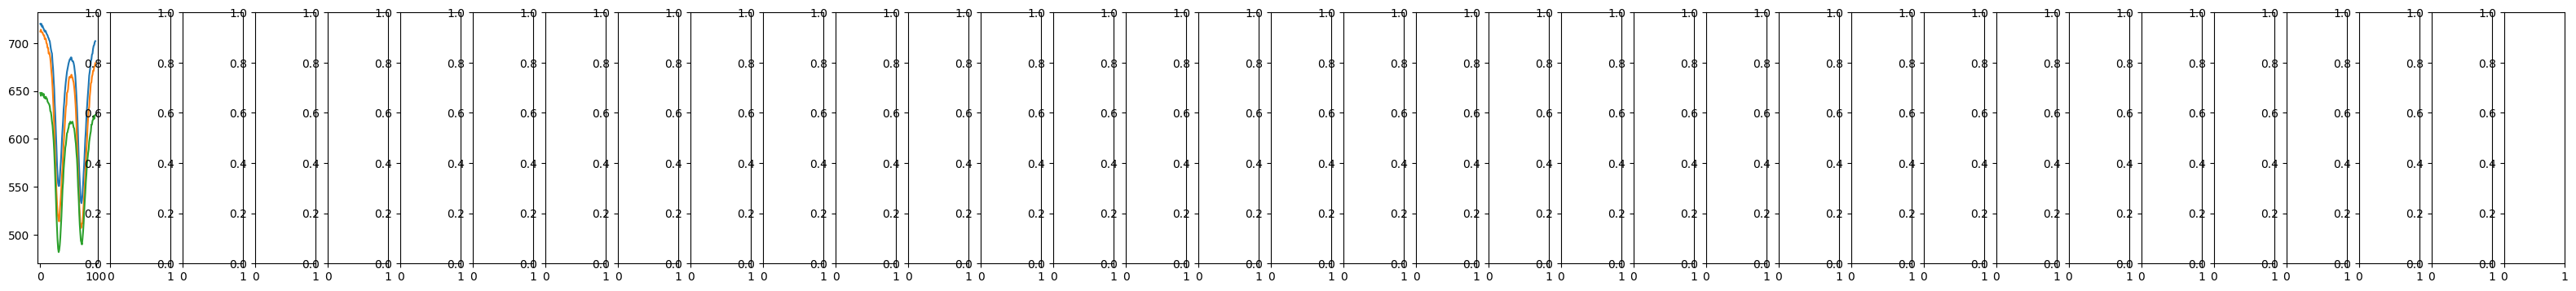

In [34]:
# Show all training data
train_amount = len(x_train)
fig, axs = plt.subplots(1, train_amount, figsize=(40, 4))
for i in range(train_amount):
    axs[i].plot(x_train[i])
    axs[i].annotate(Gestures(y_train[i]).fullname, (0,0), (0, -40), xycoords='axes fraction', textcoords='offset points', va='top')

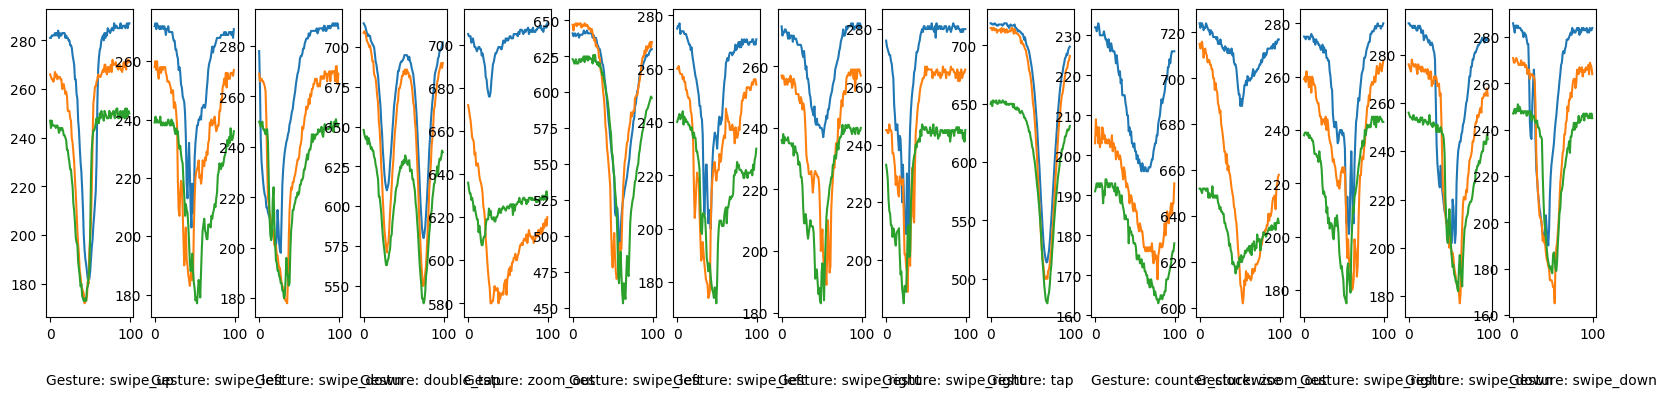

In [17]:
# Show all test data
test_amount = len(x_test)
fig, axs = plt.subplots(1, test_amount, figsize=(20, 4))
for i in range(test_amount):
    axs[i].plot(x_test[i])
    axs[i].annotate(f'Gesture: {Gestures(y_test[i]).fullname}', (0,0), (0, -40), xycoords='axes fraction', textcoords='offset points', va='top')

ValueError: x and y can be no greater than 2D, but have shapes (15,) and (15, 100, 3, 1)

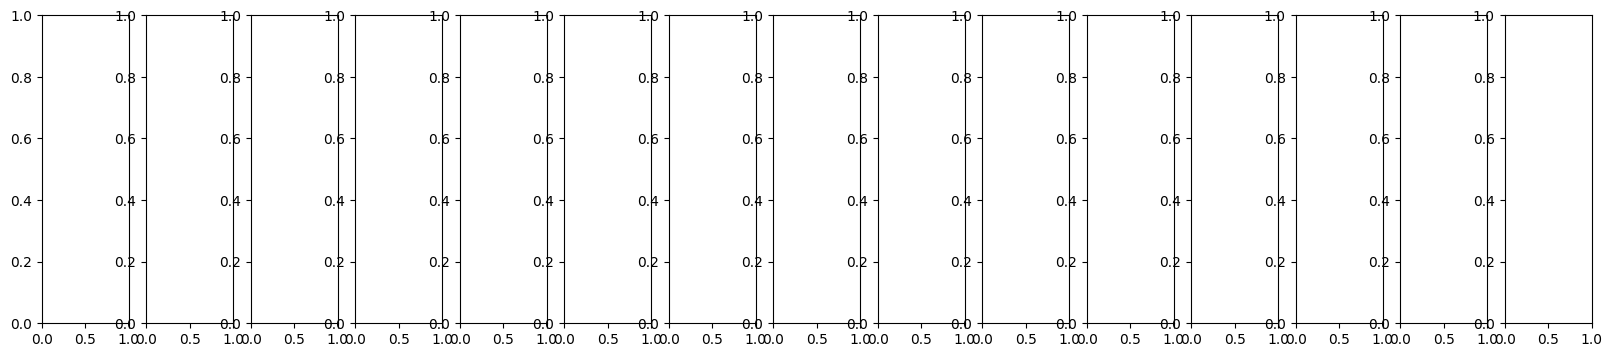

In [46]:
# Show normalized test data
test_amount = len(x_test_normalized)
fig, axs = plt.subplots(1, test_amount, figsize=(20, 4))
for i in range(test_amount):
    axs[i].plot(x_test_normalized[i])

In [19]:
# Implement data windowing
# SLICES = 5
#
# single_source = np.array(train[0], dtype=np.uint16)
# single_targets = np.full((single_source.shape[0], 1, 1), train_outcome[0])
# print(single_source.shape)
#
# train_ds = timeseries_dataset_from_array(data=single_source, targets=single_targets, sequence_length=SLICES, sequence_stride=SLICES)
#
# for example_inputs, example_labels in train_ds.take(1):
#     print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
#     print(f'Targets shape (batch, time, features): {example_labels.shape}')
#
#
# single_validation_source = np.array(test[0], dtype=np.uint16)
# single_validation_targets = np.full((single_validation_source.shape[0], 1, 1), test_outcome[0])
#
# validation_ds = keras.utils.timeseries_dataset_from_array(data=single_validation_source, targets=single_validation_targets, sequence_length=SLICES, sequence_stride=SLICES)


NameError: name 'train' is not defined

In [ ]:
# train_ds = timeseries_dataset_from_array(data=x_train, targets=y_train, sequence_length=SLICES, sequence_stride=SLICES)
# validation_ds = timeseries_dataset_from_array(data=x_test, targets=y_test, sequence_length=SLICES, sequence_stride=SLICES)

In [ ]:
# print(dir(train_ds))
# print(train_ds.element_spec)

In [47]:
USE_GPU = False
device = "/device:GPU:0" if USE_GPU else "/device:CPU:0"

with tf.device(device):
    model_simple = keras.Sequential()

    # model_lstm.add(layers.LSTM(units=128, input_shape=[1, 3]))
    model_simple.add(layers.Input(shape=(100, 3, 1), name="sensor_image"))
    model_simple.add(layers.ZeroPadding2D(padding=(0, 2)))
    model_simple.add(layers.Conv2D(8, kernel_size=(3, 3), strides=(1, 1), activation="relu"))
    model_simple.add(layers.Conv2D(16, kernel_size=(2, 2), strides=(1, 1), activation="relu"))
    model_simple.add(layers.Conv2D(16, kernel_size=(2, 2), activation="relu"))
    model_simple.add(layers.MaxPooling2D(pool_size=(3, 1)))
    model_simple.add(layers.Conv2D(16, kernel_size=(5, 1), activation="relu"))
    model_simple.add(layers.Flatten())
    model_simple.add(layers.Dropout(0.5))
    model_simple.add(layers.Dense(len(Gestures), activation="softmax", name="predictions"))
    model_simple.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc', 'mae'])
    model_simple.summary()


    start = time.perf_counter()
    simple_history = model_simple.fit(x_train_normalized, y_train, epochs=80, batch_size=2)

    end = time.perf_counter()
    print("Training took: %0.1f seconds" % (end - start))

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d_1 (ZeroPaddi  (None, 100, 7, 1)        0         
 ng2D)                                                           
                                                                 
 conv2d_4 (Conv2D)           (None, 98, 5, 8)          80        
                                                                 
 conv2d_5 (Conv2D)           (None, 97, 4, 16)         528       
                                                                 
 conv2d_6 (Conv2D)           (None, 96, 3, 16)         1040      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 3, 16)        0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 28, 3, 16)        

2023-05-15 09:28:25.475022: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f8688018790 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-05-15 09:28:25.475053: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): Host, Default Version
2023-05-15 09:28:25.493351: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-05-15 09:28:25.524545: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


18/18 [==============================] - 0s 3ms/step - loss: 2.2262 - acc: 0.3429 - mae: 0.1783
Epoch 4/80
18/18 [==============================] - 0s 3ms/step - loss: 2.2020 - acc: 0.2000 - mae: 0.1768
Epoch 5/80
18/18 [==============================] - 0s 3ms/step - loss: 2.0458 - acc: 0.2571 - mae: 0.1722
Epoch 6/80
18/18 [==============================] - 0s 3ms/step - loss: 1.8536 - acc: 0.5143 - mae: 0.1656
Epoch 7/80
18/18 [==============================] - 0s 3ms/step - loss: 1.5971 - acc: 0.5429 - mae: 0.1490
Epoch 8/80
18/18 [==============================] - 0s 3ms/step - loss: 1.3721 - acc: 0.5429 - mae: 0.1297
Epoch 9/80
18/18 [==============================] - 0s 3ms/step - loss: 1.2395 - acc: 0.5429 - mae: 0.1202
Epoch 10/80
18/18 [==============================] - 0s 3ms/step - loss: 0.8854 - acc: 0.6857 - mae: 0.0978
Epoch 11/80
18/18 [==============================] - 0s 3ms/step - loss: 0.9783 - acc: 0.6286 - mae: 0.1010
Epoch 12/80
18/18 [===========================

# Training times:
| GPU   | CPU   |
|-------|-------|
| 18.5s | 12.3s |

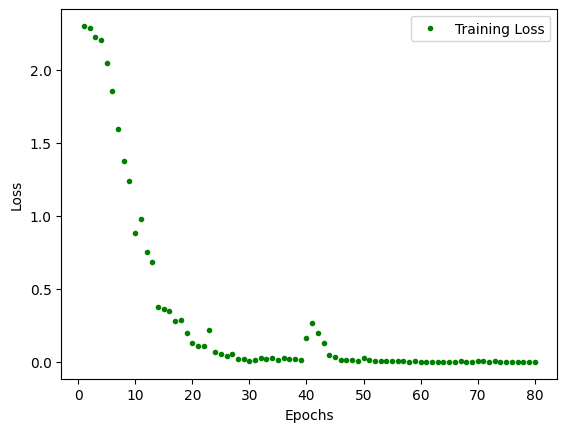

In [51]:
loss = simple_history.history['loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'g.', label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/local/lib/python3.8/dist-packages/matplotlib/mpl-data/fonts/ttf/STIXSizTwoSymBol.ttf', name='STIXSizeTwoSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/local/lib/python3.8/dist-packages/matplotlib/mpl-data/fonts/ttf/STIXSizOneSymBol.ttf', name='STIXSizeOneSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/local/lib/python3.8/dist-packages/matplotlib/mpl-data/fonts/ttf/cmtt10.ttf', name='cmtt10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/usr/local/lib/pytho

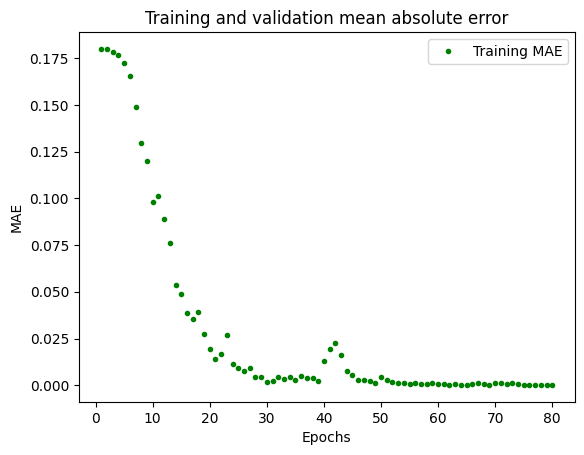

In [52]:
mae = simple_history.history['mae']

plt.plot(epochs, mae, 'g.', label='Training MAE')
plt.title('Training and validation mean absolute error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [53]:
score = model_simple.evaluate(x_test_normalized, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 8.658365249633789
Test accuracy: 0.4000000059604645


In [54]:
print(x_test_normalized.shape)

for i in range(x_test_normalized.shape[0]):
    test_sample = np.expand_dims(x_test_normalized[i], -4)
    test_prediction = model_simple.predict(test_sample)
    print("Prediction: %s, actual: %s" % (Gestures(np.argmax(test_prediction)), Gestures(np.argmax(y_test[i]))))

(15, 100, 3, 1)
1/1 [==============================] - 0s 197ms/step
Prediction: Gestures.SWIPE_UP, actual: Gestures.SWIPE_UP
1/1 [==============================] - 0s 13ms/step
Prediction: Gestures.TAP, actual: Gestures.SWIPE_LEFT
1/1 [==============================] - 0s 15ms/step
Prediction: Gestures.ZOOM_IN, actual: Gestures.SWIPE_DOWN
1/1 [==============================] - 0s 12ms/step
Prediction: Gestures.DOUBLE_TAP, actual: Gestures.DOUBLE_TAP
1/1 [==============================] - 0s 13ms/step
Prediction: Gestures.ROT_CW, actual: Gestures.ZOOM_OUT
1/1 [==============================] - 0s 13ms/step
Prediction: Gestures.ROT_CCW, actual: Gestures.SWIPE_LEFT
1/1 [==============================] - 0s 14ms/step
Prediction: Gestures.SWIPE_LEFT, actual: Gestures.SWIPE_LEFT
1/1 [==============================] - 0s 15ms/step
Prediction: Gestures.ZOOM_OUT, actual: Gestures.SWIPE_RIGHT
1/1 [==============================] - 0s 12ms/step
Prediction: Gestures.TAP, actual: Gestures.SWIPE_RI

In [55]:
USE_GPU = False
device = "/device:GPU:0" if USE_GPU else "/device:CPU:0"

with tf.device(device):
    # https://towardsdatascience.com/time-series-classification-for-human-activity-recognition-with-lstms-using-tensorflow-2-and-keras-b816431afdff
    model_lstm = keras.Sequential()

    # Subject to change as we split up the data in fragments:
    model_lstm.add(layers.Input(shape=(100, 3), name="sensor_image"))
    model_lstm.add(layers.LSTM(units=128))

    # Extra
    model_lstm.add(layers.Dropout(rate=0.5))
    model_lstm.add(layers.Dense(units=128, activation='relu'))

    # Output stage
    model_lstm.add(layers.Dense(len(Gestures), activation="softmax", name="predictions"))
    model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc', 'mae'])
    model_lstm.summary()

    start = time.perf_counter()
    lstm_history = model_lstm.fit(x_train_normalized, y_train, epochs=200, batch_size=8)

    end = time.perf_counter()
    print("Training took: %0.1f seconds" % (end - start))

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 128)               67584     
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 predictions (Dense)         (None, 10)                1290      
                                                                 
Total params: 85,386
Trainable params: 85,386
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200


2023-05-15 09:31:20.618942: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-15 09:31:20.620009: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-15 09:31:20.621011: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

5/5 [==============================] - 1s 19ms/step - loss: 2.3138 - acc: 0.1714 - mae: 0.1800
Epoch 2/200
5/5 [==============================] - 0s 19ms/step - loss: 2.2722 - acc: 0.1714 - mae: 0.1792
Epoch 3/200
5/5 [==============================] - 0s 18ms/step - loss: 2.2947 - acc: 0.1429 - mae: 0.1795
Epoch 4/200
5/5 [==============================] - 0s 18ms/step - loss: 2.2932 - acc: 0.1429 - mae: 0.1792
Epoch 5/200
5/5 [==============================] - 0s 18ms/step - loss: 2.2786 - acc: 0.1429 - mae: 0.1789
Epoch 6/200
5/5 [==============================] - 0s 19ms/step - loss: 2.2972 - acc: 0.1714 - mae: 0.1793
Epoch 7/200
5/5 [==============================] - 0s 19ms/step - loss: 2.2870 - acc: 0.2571 - mae: 0.1792
Epoch 8/200
5/5 [==============================] - 0s 18ms/step - loss: 2.2624 - acc: 0.1714 - mae: 0.1785
Epoch 9/200
5/5 [==============================] - 0s 18ms/step - loss: 2.2358 - acc: 0.1714 - mae: 0.1780
Epoch 10/200
5/5 [==============================]

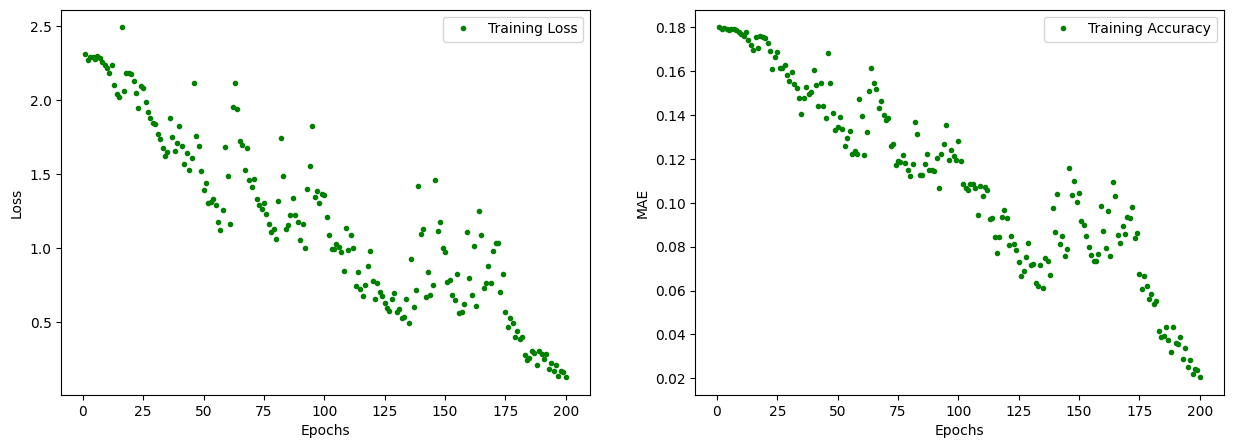

In [56]:
loss = lstm_history.history['loss']
mae = lstm_history.history['mae']

epochs = range(1, len(loss) + 1)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(epochs, loss, 'g.', label='Training Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(epochs, mae, 'g.', label='Training Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('MAE')
axs[1].legend()

fig.show()

In [57]:
score = model_lstm.evaluate(x_test_normalized, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 2.5808603763580322
Test accuracy: 0.46666666865348816


2023-05-15 09:31:50.124486: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-15 09:31:50.126051: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-15 09:31:50.127106: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus